## An Implementation of Autonomous Feature Engineering for Classification Jobs
  > **Author:**`'Bode Oyeneye`

#### Preamble
This work is inspired by the MACFE: A Meta-learning and Causality Based Feature Engineering Framework research paper available at this [arxiv link](https://arxiv.org/abs/2207.04010). Basically, it utilized feature distribution encoding as augmenting datasets, meta-learning to find the best feature transformation and a Directed Acyclic Graph (DAG) causal model for feature selection.

#### Objective
* Implementation of a sandbox for autonomous feature engineering
* Evaluation of its suitability to other sample datasets

#### Modification (departure from the MACFE paper methodology and rationales)
* It is assumed that missing data are missing at random (MAR), so imputation are conducted using MICE. However, we completely drop features that have more than 40% missing values
* Automatic selection of num of bins during histogram creation for distribution checks: with interface that allows selection of several methods: 'sturges', 'scott', 'freedman', 'sqrt', 'rice', 'doane'

### 0. Import relevant libraries

In [1]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pymfe.mfe import MFE
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from typing import List, Tuple

### 1. Define relevant functions and Classes

In [2]:
def auto_bin_selection(data, method='freedman'):
    """
    Automatically determine the optimal number of bins for a histogram.
    
    :param data: Array-like object containing the feature values
    :param method: Method to use for bin selection
        Options: 'sturges', 'scott', 'freedman', 'sqrt', 'rice', 'doane'
    
    Returns:
        int: Recommended number of bins
    """
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    data_range = np.max(data) - np.min(data)
    
    n = len(data)
    
    if n <= 1 or data_range == 0:
        return 1
    
    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))
    
    elif method == 'scott':
        std = np.std(data)
        if std == 0:
            return 1
        bin_width = 3.5 * std / np.cbrt(n)
        return int(np.ceil(data_range / bin_width))
    
    elif method == 'freedman':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.ceil(np.log2(n) + 1))
        bin_width = 2 * iqr / np.cbrt(n)
        return int(np.ceil(data_range / bin_width))
    
    elif method == 'sqrt':
        return int(np.ceil(np.sqrt(n)))
    
    elif method == 'rice':
        return int(np.ceil(2 * np.cbrt(n)))
    
    elif method == 'doane':
        if n > 2:
            skewness = stats.skew(data)
            sigma_g1 = np.sqrt(6 * (n - 2) / ((n + 1) * (n + 3)))
            
            # Add 1 to the logarithm term for more bins if there's skewness
            return int(1 + np.log2(n) + np.log2(1 + abs(skewness) / sigma_g1))
        else:
            return 1
    
    else:
        raise ValueError(
            f"Unknown method: {method}. Choose from 'sturges', 'scott', 'freedman', 'sqrt', 'rice', 'doane'"
        )

In [3]:
class ProcessedDataset:
    """Prepare dataset for Meta Feature Extraction or
    creation of frequency distribution sets

    :param imputer: An instance of Scikit-Learn imputer, with option
            being Simple Imputer, KNN Imputer or Iterative Imputer
    """
    def __init__(
        self,
        imputer: IterativeImputer|KNNImputer|SimpleImputer = (
            IterativeImputer(random_state=0)
        )
    ):
        self.contain_label = False
        self.label_col = None
        self.imputer = imputer
        self.is_df = None
                 
    def get_df_label(self, df: pd.DataFrame) -> str:
        """
        Extract label column from a pandas df
    
        :param df: The pandas dataframe whose label we
            are interested in
    
        :Return
            `str`: label name
        """
        potential_label_name = set([
            'target','outcome','label','y','class',
            'response','price','score','target_variable'
        ])
        for col in df.columns:
            if col in potential_label_name:
                return col
        return None


    def clean_df_dtype(self, data: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        """
        Make sure numeric-like columns are converted to
        the right datatype
    
        :param data: The pandas dataframe | np.ndrray whose datatype
            is being cleaned
            
        :Return
            `pandas.DataFrame | np.ndrray: data with well-defined
                numerical datatype
        """
        if isinstance(data, np.ndarray):
            df = pd.DataFrame(data)
        else:
            df = data.copy()
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                print(f"The {col} column could not be converted to numeric.")
                pass
        return df.to_numpy() if isinstance(data, np.ndarray) else df
        

    def extract_numerical_data(self, data: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        """
        Extract numerical data either from pd.DataFrame or np.ndarray
    
        :param data: The pandas dataframe | np.ndrray used for the extraction

        :Return
            `pandas.DataFrame | np.ndrray: numerical data only
        """
        is_df = True
        
        if isinstance(data, np.ndarray):
            data = pd.DataFrame(data)
            is_df = False
            
        numerical_data = data.select_dtypes(include=np.number)
        if numerical_data.empty:
            return "The dataset has no numerical value"

        return numerical_data.to_numpy() if not is_df else numerical_data  
        

    def impute_data(
        self,
        data: pd.DataFrame|np.ndarray,
    ) -> np.ndarray:
        """
        Impute missing values in the data based on a selected strategy
        
        :param data: Either a pandas dataframe or numpy dataset that
            needed to be imputed
    
        :Return:
            `np.ndarray` - The imputed data
        """
        cols = None
        if isinstance(data, pd.DataFrame):
            cols = data.columns
            data = data.to_numpy()
    
        imputed_data = self.imputer.fit_transform(data)
        return (
            pd.DataFrame(imputed_data,columns=cols)
            if not cols is None else imputed_data
        )

    def prepare_dataset(
        self,
        data: pd.DataFrame|np.ndarray,
        contain_label: bool = True, 
        label_col: str | int = None,
    ) -> pd.DataFrame|np.ndarray:
        """
        Remove label, clean numerical col datatypes and impute
        missing values in data

        :param data: pd.DataFrame | np.ndarray type dataset
        :param contain_label: Is either True or False
        :param label_col: This is more of an identifier for the label
            if dataset is numpy then it should be an integer, else it
            should be a string value

        :Return:
            `pd.DataFrame|np.ndarray` - imputed data
        """

        self.contain_label = contain_label
        self.label_col = label_col
        self.cols = None
        
        if isinstance(data, pd.DataFrame):
            self.is_df = True
        else:
            self.is_df = False

        if self.contain_label and self.is_df:
            if self.label_col is None:
                self.label_col = self.get_df_label(data)
                self.cols = data.columns
            if not self.label_col is None:
                data = data.drop(columns=[self.label_col])
            
        elif self.contain_label and not self.is_df:
            if not self.label_col is None:
                if isinstance(self.label_col, int):
                    data = np.hstack(
                        (
                            data[:,:self.label_col],
                            data[:,(self.label_col+1):]
                        )
                    )
        
        data = self.clean_df_dtype(data)
        num_data = self.extract_numerical_data(data)

        return self.impute_data(num_data)

In [4]:
def compute_mfe_vector(
    X: np.ndarray | pd.DataFrame,
    mfe_categories: List[str] = [
        "general", "statistical", "info-theory", "landmarking", "model-based"
    ]
)-> np.ndarray:
    """
    Meta-feature extractor from clean dataset: np.ndarray

    :param X: The dataset whose meta features we want to extract
    :param mfe_categogies: A list containing all meta feature groups
        to be considered.

    :Return
        `np.ndarray` - MFE vector
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    mfe = MFE(groups=mfe_categories)
    mfe.fit(X)
    ft = mfe.extract()

    return dict(zip(ft[0],ft[1]))


def get_feature_distribution(
    data: pd.Series | np.ndarray,
    num_bins: int = 10,
    # bin_method: str = 'freedman'
):
    """
    Generate histogram distribution for each feature in a dataset
    Normalize distribution

    :param data: The feature whose distribution we want to determine
    :param num_bins: number of bins to use for the histogram
    # :bin_method: Strategy for automatically determining the num
    #     of bin to used.

    :Return
        `List[float]` - Normalized histogram distribution
    """
    num_bins = auto_bin_selection(data=data, method=bin_method)
    counts, bin_edges = np.histogram(data, bins=num_bins)
    return counts/len(data), bin_edges

In [5]:
def plot_frequency_table(feature_name: str, frequency_table: Tuple[float,float]):
    """
    Plots a frequency table (histogram).
    
    :param feature_name (str): The name of the feature.
    :param frequency_table (np.ndarray): The normalized frequency table.
    
    :Return: 
        Plot
    """
    bin_edges = frequency_table[1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 
    
    plt.figure(figsize=(8, 6)) 
    plt.bar(
        bin_centers, frequency_table[0], 
        width=(bin_edges[1]-bin_edges[0]), 
        align='center', alpha=0.7
    )
    plt.xlabel(feature_name)
    plt.ylabel("Normalized Frequency")
    plt.title(f"Frequency Table for {feature_name}")
    plt.grid(axis='y', alpha=0.5)  # Add a grid
    plt.show()

### 2. Implementation
--------------------

#### 2.1 Extract raw data

In [6]:
iris_data = load_iris()
y = iris_data.target
X = iris_data.data
col_names = iris_data.feature_names

df = pd.DataFrame(X, columns=col_names)
df['target'] = y

#### 2.2 Process the raw data

In [7]:
processer = ProcessedDataset()
processed_dataset = processer.prepare_dataset(df)

#### 2.3 Generate Meta Features for the processed data

In [8]:
mfe_vector_dict = compute_mfe_vector(processed_dataset)

#### 2.4 Compute normalized histogram distribution for each feature

In [9]:
num_bins = 0
for col in processed_dataset.columns:
    num_bins = max(
        num_bins, 
        auto_bin_selection(processed_dataset[col], method='freedman')
    )
    
print(num_bins)
dist_dict = {}
for col in processed_dataset.columns:
    dist_dict[col] = (
        get_feature_distribution(processed_dataset[col], num_bins )
    )

dist_dict

13


{'sepal length (cm)': (array([0.03333333, 0.07333333, 0.16666667, 0.07333333, 0.08666667,
         0.12      , 0.10666667, 0.14      , 0.06666667, 0.05333333,
         0.03333333, 0.01333333, 0.03333333]),
  array([4.3       , 4.57692308, 4.85384615, 5.13076923, 5.40769231,
         5.68461538, 5.96153846, 6.23846154, 6.51538462, 6.79230769,
         7.06923077, 7.34615385, 7.62307692, 7.9       ])),
 'sepal width (cm)': (array([0.00666667, 0.04666667, 0.07333333, 0.09333333, 0.16      ,
         0.24666667, 0.08666667, 0.12      , 0.06666667, 0.06      ,
         0.02      , 0.01333333, 0.00666667]),
  array([2.        , 2.18461538, 2.36923077, 2.55384615, 2.73846154,
         2.92307692, 3.10769231, 3.29230769, 3.47692308, 3.66153846,
         3.84615385, 4.03076923, 4.21538462, 4.4       ])),
 'petal length (cm)': (array([0.16      , 0.17333333, 0.        , 0.        , 0.00666667,
         0.04      , 0.08      , 0.14      , 0.12      , 0.11333333,
         0.09333333, 0.04666667, 0

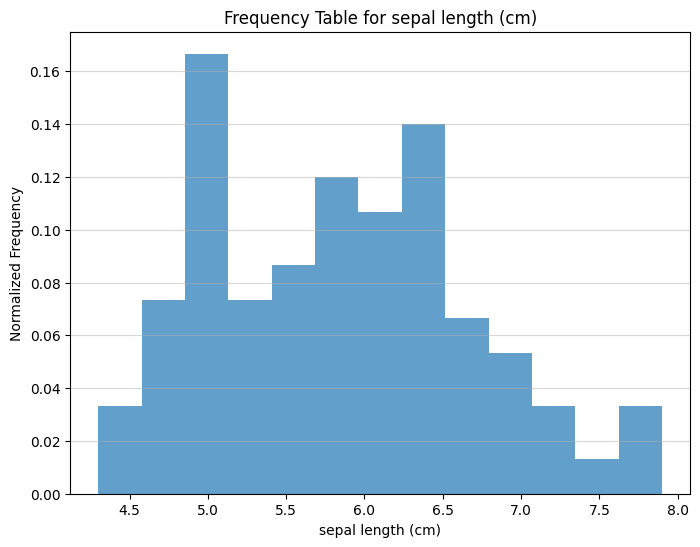

In [10]:
plot_frequency_table('sepal length (cm)', dist_dict['sepal length (cm)'])

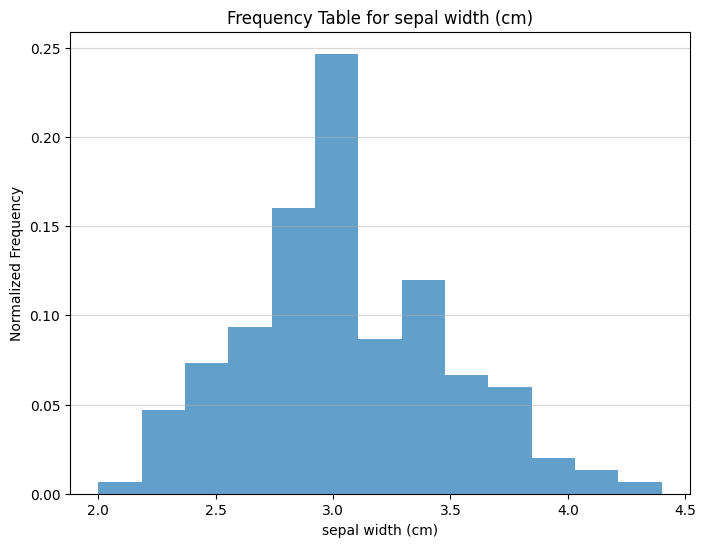

In [11]:
plot_frequency_table('sepal width (cm)', dist_dict['sepal width (cm)'])

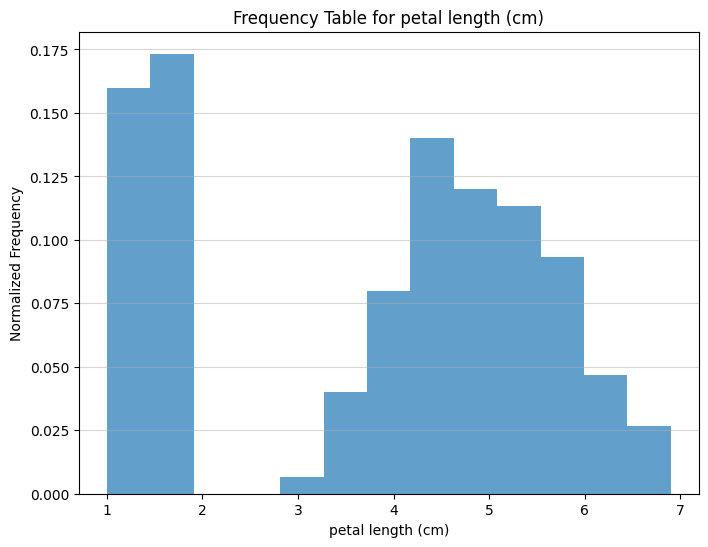

In [12]:
plot_frequency_table('petal length (cm)', dist_dict['petal length (cm)'])

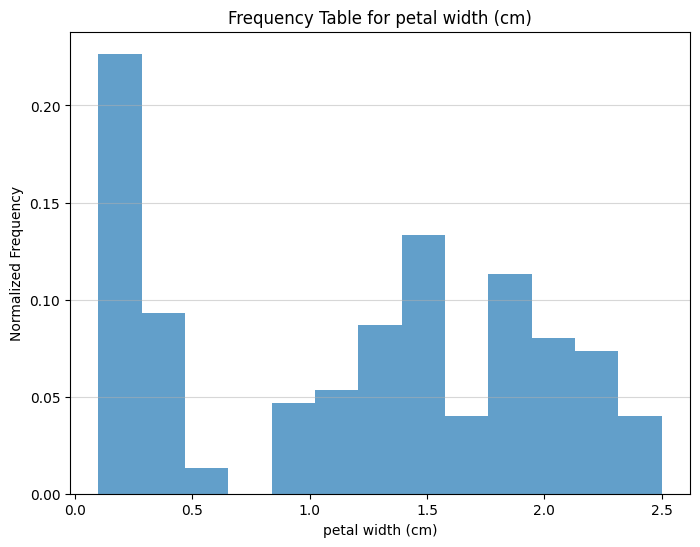

In [13]:
plot_frequency_table('petal width (cm)', dist_dict['petal width (cm)'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from pymfe.mfe import MFE
from itertools import combinations  # For generating feature pairs
from scipy.stats import pearsonr #alternative to MIC
import warnings
warnings.filterwarnings("ignore") #suppress warnings from Sklearn
# Define Transformations (Illustrative - Expand this!)
def log_transform(x):
    return np.log(np.abs(x) + 1e-9)  # Add a small constant to avoid log(0) and non-defined values


def square_transform(x):
    return x**2


def interaction_transform(x1, x2):
    return x1 * x2

# scaling transformations
def normalize(x):
    min_x = np.min(x)
    max_x = np.max(x)
    return (x - min_x) / (max_x - min_x)

def standardize(x):
    mean_x = np.mean(x)
    std_x = np.std(x)
    return (x - mean_x) / std_x


class MACFE_DatasetPreprocessor:
    """
    Preprocesses datasets for the MACFE framework and implements Algorithm 1
    """

    def __init__(self, num_bins=10, openml_id=None, mic_threshold=0.1): #added the mic threshold
        """
        Initializes the preprocessor.

        Args:
            num_bins (int): Number of bins for frequency tables.
            openml_id (int, optional): OpenML dataset ID (placeholder).
            mic_threshold (float): Minimum MIC score for selecting transformations.
        """
        self.num_bins = num_bins
        self.imputer = SimpleImputer(strategy='mean')
        self.bin_edges = {}
        self.openml_id = openml_id
        self.mic_threshold = mic_threshold
        self.unary_transformations = {'log': log_transform,
                                      'square': square_transform,
                                      'normalize':normalize,
                                      'standardize': standardize}
        self.binary_transformations = {'interaction': interaction_transform}
        self.TRM = {}  # Transformation Recommendation Matrix


    def preprocess(self, df):
        """
        Preprocesses the DataFrame (removes non-numerical, imputes, encodes target).
        """

        # Store target variable if it exists, then encode and store it before dropping it
        original_target = None
        if 'target' in df.columns:
            original_target = df['target'].copy() # Store for later use
            label_encoder = LabelEncoder()
            df['target'] = label_encoder.fit_transform(df['target'])

        # 1. Remove Non-Numerical Features
        df_numerical = df.select_dtypes(include=np.number) #select numeric
        if 'target' in df.columns:
           df_numerical['target'] = df['target']  # add target back after selecting only numerical types

        # 2. Impute Missing Values
        # Fit imputer
        self.imputer.fit(df_numerical)

        # transform dataframe
        df_imputed = pd.DataFrame(self.imputer.transform(df_numerical), columns=df_numerical.columns)

        return df_imputed, original_target

    def extract_metafeatures(self, df, target):
        """
        Extracts meta-features from the dataset.
        """
        # Pymfe expects the target variable as a numpy array.
        if target is not None:
          target = target.to_numpy()
        # Convert dataframe to numpy array, since pymfe expects that format
        X = df.drop(columns=['target']).to_numpy() if 'target' in df.columns else df.to_numpy()
        y = target if target is not None else None

        mfe = MFE(groups=["general", "statistical", "info-theory", "model-based", "landmarking"]) # specify groups
        mfe.fit(X, y)
        extracted_features = mfe.extract()

        # Convert results into a dictionary for clarity
        metafeature_dict = {}
        for name, value in zip(extracted_features[0], extracted_features[1]): #extracted_features has two tuples
            metafeature_dict[name] = value

        return metafeature_dict

    def create_frequency_tables(self, df):
        """
        Creates frequency tables (histograms) for each numerical feature.
        """
        frequency_tables = {}

        for col in df.columns:
            if col == 'target':  # Skip target variable
                continue

            # 1. Calculate the Range
            min_val = df[col].min()
            max_val = df[col].max()

            # 2. Generate Bins
            bin_edges = np.linspace(min_val, max_val, num=self.num_bins + 1)  # Include both endpoints
            self.bin_edges[col] = bin_edges  # Store for consistent binning

            # 3. Create Histogram (Frequency Table)
            hist, _ = np.histogram(df[col], bins=bin_edges)

            # 4. Normalize the Histogram
            total_count = len(df[col])
            normalized_hist = hist / total_count

            frequency_tables[col] = normalized_hist

        return frequency_tables



    def calculate_mic(self, x, y):
          """Calculates Pearson correlation"""

          corr, _ = pearsonr(x, y)
          return abs(corr) #return abs correlation

    def train_trm(self, df, target):
        """
        Implements Algorithm 1 to train the Transformation Recommendation Matrix (TRM).
        """
        self.TRM = {} #restart the TRM

        # Get the names of the features (excluding the target, if it exists)
        features = [col for col in df.columns if col != 'target']

        # Iterate through each feature
        for xi in features:

            # 1. Create the encoding ei
            ei = self.encode_feature(df, xi)
            self.TRM[xi] = {} #create the feature in the TRM

            # 2. Unary Transformations
            s_unary = {}  # Store MIC score improvements for each unary transformation
            for t_name, t_func in self.unary_transformations.items():
                try:
                    Xi = t_func(df[xi])
                    #s = self.calculate_mic(df[xi], target) - self.calculate_mic(Xi, target)
                    #Ensure both input series are numeric
                    if pd.api.types.is_numeric_dtype(df[xi]) and pd.api.types.is_numeric_dtype(target):
                      s = self.calculate_mic(df[xi], target) - self.calculate_mic(Xi, target)
                      s_unary[t_name] = s

                except Exception as e:
                    print(f"Error applying unary transform {t_name} on {xi}: {e}")
                    s_unary[t_name] = -1 # mark as bad

            # Select the best unary transformation (ttop)
            if s_unary:
                ttop_unary = max(s_unary, key=s_unary.get)
                if s_unary[ttop_unary] > self.mic_threshold: #Only record if the mic change is above threshold
                  self.TRM[xi]['unary'] = (ttop_unary, s_unary[ttop_unary]) #Store the selected unary transformation, and the mic value


            # 3. Binary Transformations
            for xj in features:
                if xi == xj: #skip if they are the same
                  continue
                s_binary = {}  # Store MIC score improvements for each binary transformation
                for t_name, t_func in self.binary_transformations.items():
                    try:
                        Xij = t_func(df[xi], df[xj])
                        if pd.api.types.is_numeric_dtype(df[xi]) and pd.api.types.is_numeric_dtype(target) and pd.api.types.is_numeric_dtype(df[xj]):
                          si = self.calculate_mic(df[xi], target) - self.calculate_mic(Xij, target)
                          sj = self.calculate_mic(df[xj], target) - self.calculate_mic(Xij, target)
                          if si > self.mic_threshold and sj > self.mic_threshold: #only recommend if both si and sj meet the threshhold
                            s_binary[t_name] = (si, sj) #store both mic values

                    except Exception as e:
                        print(f"Error applying binary transform {t_name} on {xi} and {xj}: {e}")
                        # s_binary[t_name] = 0 #or any default
                        s_binary[t_name] = (0,0) # set it to zero

                if s_binary:
                    #find the binary op with the best sum
                    ttop_binary = max(s_binary, key=lambda k: sum(s_binary[k])) #added a check for empty dictionaries
                    #store the result if it meet the threshold
                    self.TRM[xi][xj] = (ttop_binary, s_binary[ttop_binary])



    def encode_feature(self, df, feature_name):
        """
        Encodes a feature into a vector consisting of metafeatures and feature distribution.

        Args:
            df (pd.DataFrame): The DataFrame.
            feature_name (str): The name of the feature to encode.

        Returns:
            list: The encoding vector.
        """

        # Create frequency table for the feature
        frequency_tables = self.create_frequency_tables(df[[feature_name]])  # Pass a DataFrame containing only the single feature
        feature_histogram = frequency_tables[feature_name]

        # Extract dataset-level metafeatures
        if 'target' in df.columns:
          metafeatures = self.extract_metafeatures(df, df['target']) #original target is required
        else:
          metafeatures = self.extract_metafeatures(df, None) #if there is not target variable in the dataframe

        # Concatenate metafeatures and histogram, converting numpy arrays to lists
        encoding = list(metafeatures.values()) + list(feature_histogram) #metafeatures.values to get just the value
        return encoding #to list

# Example Usage:
data = {'feature1': [1, 2, 3, 4, 5, 6],
        'feature2': [7, 8, 9, 10, 11, 12],
        'target': [0, 1, 0, 1, 0, 1]}
df = pd.DataFrame(data)

preprocessor = MACFE_DatasetPreprocessor(num_bins=5, mic_threshold = 0.1)

#encode
df_processed, original_target = preprocessor.preprocess(df)
frequency_tables = preprocessor.create_frequency_tables(df_processed)
# Train the TRM
preprocessor.train_trm(df_processed, df_processed['target'])

print("Transformation Recommendation Matrix (TRM):\n", preprocessor.TRM)

In [ ]:
/usr/local/bin
/opt/homebrew/opt/openjdk@17/bin
/opt/homebrew/opt/apache-spark/libexec/bin
/opt/homebrew/opt/python@3.10/bin

/usr/local/bin
/opt/homebrew/opt/openjdk@17/bin
/opt/homebrew/opt/apache-spark/libexec/bin
/opt/homebrew/opt/python@3.10/bin


export PATH="/opt/homebrew/opt/python@3.10/bin:$PATH"
export JAVA_HOME="/opt/homebrew/opt/openjdk@17"
export SPARK_HOME="/opt/homebrew/opt/apache-spark/libexec"
export PATH="$JAVA_HOME/bin:$SPARK_HOME/bin:$PATH"
export PATH=/usr/local/bin:$PATH


In [ ]:
/opt/homebrew/bin
/opt/homebrew/sbin
/usr/local/bin


/opt/homebrew/opt/openjdk@17/bin
/opt/homebrew/opt/apache-spark/libexec/bin
/opt/homebrew/opt/python@3.10/bin


/System/Cryptexes/App/usr/bin
/usr/bin
/bin
/usr/sbin
/sbin
/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin
/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin
/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin
/Library/Apple/usr/bin